In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
#Load dataset
n_components = 2
data = pd.read_csv('/content/bmd.csv')
data = data[['age','weight_kg','height_cm','bmd','fracture']]
data

,age,weight_kg,height_cm,bmd,fracture
0,57.052768,64.0,155.5,0.8793,no fracture
1,75.741225,78.0,162.0,0.7946,no fracture
2,70.778900,73.0,170.5,0.9067,no fracture
3,78.247175,60.0,148.0,0.7112,no fracture
4,54.191877,55.0,161.0,0.7909,no fracture
...,...,...,...,...,...
164,77.982543,74.0,164.0,0.7941,fracture
165,50.285303,59.0,161.0,0.7971,fracture
166,46.359721,67.0,169.0,0.8037,fracture
167,54.788368,70.0,166.0,0.8072,fracture


In [2]:
#Normalizing the attributes and encoding labels
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(data.iloc[:,range(0,4)].values)
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(data['fracture'].values)
#Between class variance
S_W = np.zeros((4,4))
for i in range(2):
    S_W += np.cov(X_train_std[y==i].T)
S_W

array([[ 1.9725685 , -0.04759746, -0.42736814, -0.30524193],
       [-0.04759746,  1.78794962,  0.71452081,  0.59460869],
       [-0.42736814,  0.71452081,  2.03028906,  0.56144434],
       [-0.30524193,  0.59460869,  0.56144434,  1.0964439 ]])

In [3]:
#Distance between mean and sample of class
N=np.bincount(y)
vecs=[]
[vecs.append(np.mean(X_train_std[y==i],axis=0)) for i in range(2)]
mean_overall = np.mean(X_train_std, axis=0)
S_B=np.zeros((4,4))
for i in range(2):
    S_B += N[i]*(((vecs[i]-mean_overall).reshape(4,1)).dot(((vecs[i]-mean_overall).reshape(1,4))))
S_B #Display eigen values

array([[ 17.63488395, -19.24443281,  -4.31743302, -34.05701777],
       [-19.24443281,  21.00088638,   4.71148831,  37.16542689],
       [ -4.31743302,   4.71148831,   1.05700882,   8.33795637],
       [-34.05701777,  37.16542689,   8.33795637,  65.77193605]])

In [4]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,key=lambda k: k[0], reverse=True)
print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

69.77622956845525
2.9078998724795312e-15
2.9078998724795312e-15
0.0


In [5]:
#Finding LD1 & LD2
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
W=np.hstack((eigen_pairs[0][1][:,].reshape(4,1),eigen_pairs[1][1][:, ].reshape(4,1))).real
X_train_lda = X_train_std.dot(W)
#Adding LD1 & LD2 Value to dataframe
data=pd.DataFrame(X_train_lda)
data['class']=y
data.columns=["LD1","LD2","class"]
data.head()

,LD1,LD2,class
0,-0.794078,0.361718,1
1,0.041572,-0.642138,1
2,-0.325557,-1.110186,1
3,0.233302,-0.170556,1
4,-0.061762,0.367884,1


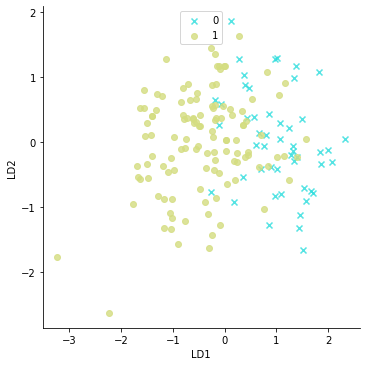

In [6]:
#Visualizing the data after LDA
import seaborn as sns
markers = ['x','o']
sns.lmplot(x="LD1", y="LD2", data=data, markers=markers,fit_reg=False, hue='class',legend=False, palette='rainbow')
plt.legend(loc='upper center')
plt.show()

In [9]:
#KNN Classifier
X_train, X_test, y_train, y_test = train_test_split(data[['LD1','LD2']], data['class'],
test_size=0.20)
knn_lda= KNeighborsClassifier(n_neighbors=3)
knn_lda.fit(X_train, y_train)
y_pred = knn_lda.predict(X_test)
print("Train accuracy ",knn_lda.score(X_train,y_train)*100,"%")
print("Test accuracy ",knn_lda.score(X_test,y_test)*100,"%")

Train accuracy  90.37037037037037 %
Test accuracy  91.17647058823529 %


In [11]:
from sklearn import metrics
knn_lda_y_pred = knn_lda.predict(X_test)
confusion = metrics.confusion_matrix(y_true = y_test, y_pred = knn_lda_y_pred)
print(confusion)
class_wise = metrics.classification_report(y_true=y_test, y_pred=knn_lda_y_pred)
print(class_wise)

[[11  2]
 [ 1 20]]
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.91      0.95      0.93        21

    accuracy                           0.91        34
   macro avg       0.91      0.90      0.91        34
weighted avg       0.91      0.91      0.91        34

